In [3]:
import jax.numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
from jax import jit, grad, jacfwd, jacrev

import numpy as onp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.io.fits as pf
import xara
import xaosim as xs
from xaosim.pupil import PHARO

from tqdm import tqdm
import pickle, gzip

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")

In [4]:
tgt_cube = pf.getdata('tgt_cube.fits').astype('float64') # alpha Ophiuchi
ca2_cube = pf.getdata('ca2_cube.fits').astype('float64') # epsilon Herculis


In [5]:
pscale = 25.0e-3              # plate scale of the image in mas/pixels
wl     = 2.145e-6          # central wavelength in meters (Hayward paper)
ISZ    = tgt_cube.shape[1] # image size


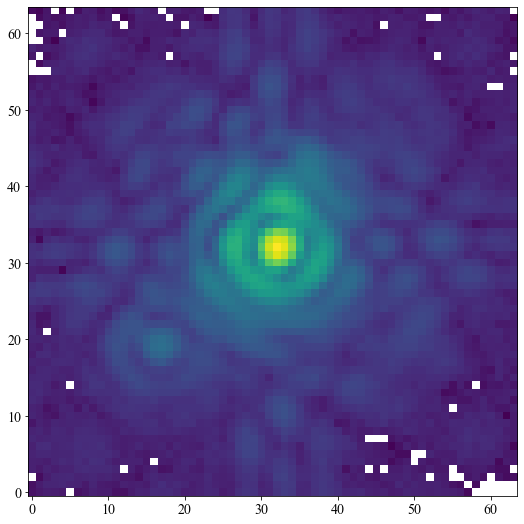

In [6]:
j = 0

plt.imshow(tgt_cube[j,:,:]**0.25)

In [7]:
from xara.core import recenter

In [8]:
PSZ     = 128   # size of the array for the model
# pdiam   = 4.978    # telescope diameter in meters
pdiam   = 4.646    # telescope diameter in meters

pmask  = PHARO(PSZ, PSZ/2, mask="med", ang=-2) # rotated!
ppscale = pdiam / PSZ
pscale = 0.0250

wl = 2.145e-6 

In [9]:
arcsec2rad = np.pi/180./3600.

from morphine.matrixDFT import minimal_dft

def calc_uv(image,pixelscale,pupil_diam,wavelength,npix=128,return_coords=False):
    nlamd = arcsec2rad*pixelscale * image.shape[0] / wavelength*2*pupil_diam
    if return_coords == True:
        x = np.linspace(-pupil_diam,pupil_diam,npix)
        coords = np.meshgrid(x,x)
        return minimal_dft(image.astype('complex64'), nlamd, npix), coords
    else:
        return minimal_dft(image.astype('complex64'), nlamd, npix)

In [10]:
pscale

0.025

In [11]:
img = tgt_cube[j,:,:]

uv, coords = calc_uv(img,pscale,pdiam,wl,return_coords=True)

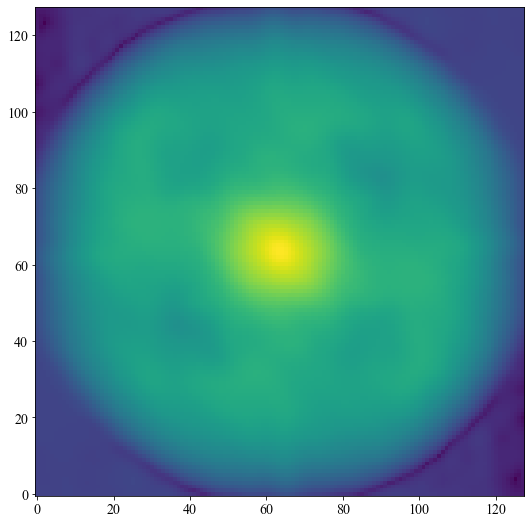

In [12]:
plt.imshow(np.abs(uv)**0.25)

In [13]:
from morphine.morphine_core import phase_binary

In [14]:
u, v = coords[0].ravel(),coords[1].ravel()
p = [200,30,25]

phases = phase_binary(u,v,wl,p)

In [15]:
phases

DeviceArray([-2.26418374, -2.21524452, -2.14312215, ...,  2.14312215,
              2.21524452,  2.26418374], dtype=float64)

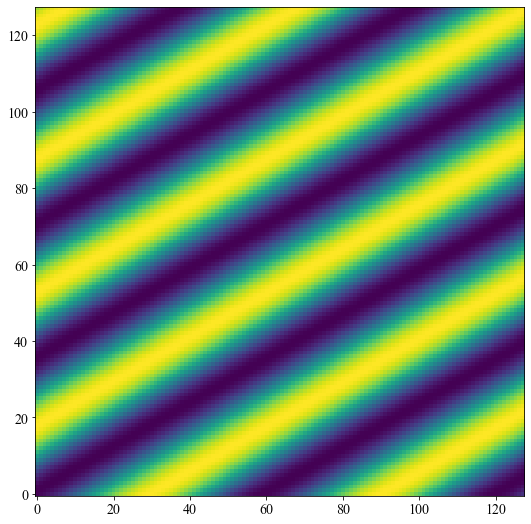

In [16]:
plt.imshow(phases.reshape(uv.shape))

### Now let's connect it to Xara

In [17]:
kp_fname = "pharomorphine_96.kpi.gz"
kp_fname = 'pharomorphine_full_128.kpi.gz'
# kp_fname = 'pharomorphine_full_64.kpi.gz'
# kp_fname = "pharomorphine_full_64_rev.kpi.gz"
# kp_fname = 'pharomorphine_full_96.kpi.gz'
kp_fname = "pharomorphine_wide_64.kpi.gz"
kp_fname = "pharomorphine_vwide_64.kpi.gz"
kp_fname = "pharomorphine_vvwide_64.kpi.gz"
# kp_fname = 'pharomorphine_fov_64.kpi.gz'
kp_fname = 'pharomorphinefrantz.kpi.gz'
kp_fname = 'pharomorphinefrantz_new.kpi.gz'
# kp_fname = 'pharomorphinefrantz_128.kpi.gz'
kp_fname = 'pharomorphinefrantz_64bit_64pix.kpi.gz'
# kp_fname = "pharomorphinefrantz_64bit_65pix.kpi.gz"
# kp_fname = "pharomorphinefrantz_64bit_128pix.kpi.gz"
# kp_fname = "pharomorphine_vvwide_64.kpi.gz"
# kp_fname = "pharomorphinefrantz_64bit_96pix.kpi.gz"
kp_fname = 'pharomorphinefrantz_32bit_64pix.kpi.gz'
# kp_fname = 'pharomorphinefrantz_64bit_64pix.kpi.gz'
# kp_fname = 'pharomorphinefrantz2_32bit_64pix.kpi.gz'

In [18]:
pscale

0.025

In [73]:
offset = 0.5

myf = gzip.open(kp_fname, "r")
stuff = pickle.load(myf)
myf.close()

c = xara.KPO(fname=kp_fname,offset=offset)#

kpo1   = c.copy()#xara.KPO(fname=kp_fname,offset=offset)
# kpo2   = xara.KPO(fname="p3k_med_grey_model.fits")
# kpo2 = kpo1.copy()
kpo2   = c.copy()#xara.KPO(fname=kp_fname,offset=offset)


kpo_frantz   = xara.KPO(fname="p3k_med_grey_model.fits")

kpo1.extract_KPD_single_cube(
        tgt_cube, pscale*1000, wl,target="alpha Ophiuchi", recenter=True)
kpo2.extract_KPD_single_cube(
        ca2_cube, pscale*1000, wl, target="epsilon Herculis", recenter=True)


Attempting to load file pharomorphinefrantz_32bit_64pix.kpi.gz
KPI data successfully loaded
File provided is not a fits file
Attempting to load file p3k_med_grey_model.fits
KPI data successfully loaded
The file contains 0 data-sets
CWAVEL was not set
No covariance data available

Cube slice   1 / 100First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!
Cube slice 100 / 100
Cube slice   1 / 100First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!
Cube slice 100 / 100

In [74]:
myf = gzip.GzipFile(kp_fname, "r")
data = pickle.load(myf)
myf.close()

kernel = data['KerPhi']
support = data['support']

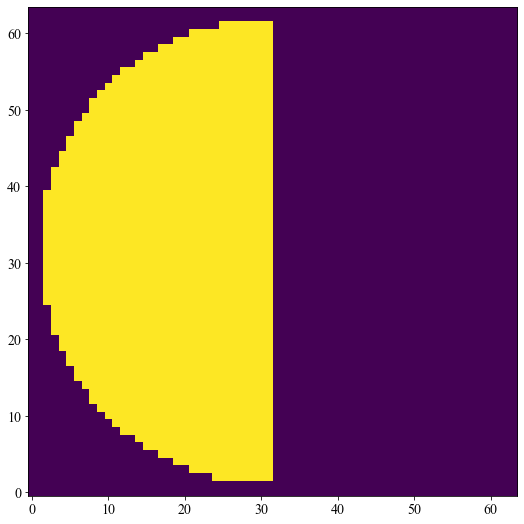

In [75]:
plt.imshow(support==1)

In [76]:
# ### try my approach to extracting manually
# science = []
# calib = []
# npix = 65
# npix= 129
# npix= 64
# calib_vis = []

# for j in tqdm(range(100)):
# #     img = recenter(tgt_cube[j,:,:],verbose=False)
#     img = tgt_cube[j,:,:]
#     uv, coords = calc_uv(img,pscale,pdiam,wl,return_coords=True,npix=npix)
#     phases = onp.angle(uv)
#     science.append(np.dot(kernel,phases[support==1]))
    
# for j in tqdm(range(100)):
# #     img = recenter(ca2_cube[j,:,:],verbose=False)
#     img = ca2_cube[j,:,:]

#     uv, coords = calc_uv(img,pscale,pdiam,wl,return_coords=True,npix=npix)
#     phases = onp.angle(uv)
#     calib_vis.append(onp.abs(uv)[support==1])
#     calib.append(np.dot(kernel,phases[support==1]))
    
# science = np.array(science)
# calib = np.array(calib)
# calib_vis = np.array(calib_vis)

In [77]:
# img = tgt_cube[j,:,:]

# uv, coords = calc_uv(img,pscale,pdiam,wl,return_coords=True,npix=npix)
# dummy = onp.angle(uv)
# dummy[support==0] = onp.nan

# plt.imshow(dummy)

In [78]:
# data1 = np.median(science, axis=0)
# data2 = np.median(calib, axis=0)
# calib_vis = np.median(calib_vis,axis=0)

# mydata = data1 - data2
# myerr  = np.sqrt(np.var(science, axis=0) / (science[0].shape[0] - 1) + np.var(calib, axis=0) / (calib[0].shape[0] - 1))
# myerr = np.sqrt(myerr**2) + 0.01365


In [79]:
# data1 = np.array(kpo1.KPDT)[0]
# data2 = np.array(kpo2.KPDT)[0]

# mydata = np.median(data1, axis=0) - np.median(data2, axis=0)
# myerr  = np.sqrt(np.var(data1, axis=0) / (kpo1.KPDT[0].shape[0] - 1) + np.var(data2, axis=0) / (kpo2.KPDT[0].shape[0] - 1))
# myerr = np.sqrt(myerr**2 +  0.015**2)


In [80]:
data1 = np.array(kpo1.KPDT)[0]
data2 = np.array(kpo2.KPDT)[0]

mydata = np.median(data1, axis=0) - np.median(data2, axis=0)
myerr  = np.sqrt(np.var(data1, axis=0) / (kpo1.KPDT[0].shape[0] - 1) + np.var(data2, axis=0) / (kpo2.KPDT[0].shape[0] - 1))
# myerr = np.sqrt(myerr**2 + 1.2**2)


In [81]:
data1 = np.array(kpo1.KPDT)[0]
data2 = np.array(kpo2.KPDT)[0]
myerr  = np.sqrt(np.var(data1, axis=0) / (kpo1.KPDT[0].shape[0] - 1) + np.var(data2, axis=0) / (kpo2.KPDT[0].shape[0] - 1))
# myerr = np.sqrt(myerr**2 + 0.0132**2)
# myerr = np.sqrt(0.0132**2)

data1 = np.median(data1,axis=0)
data2 = np.median(data2,axis=0)


mydata = data1 - data2


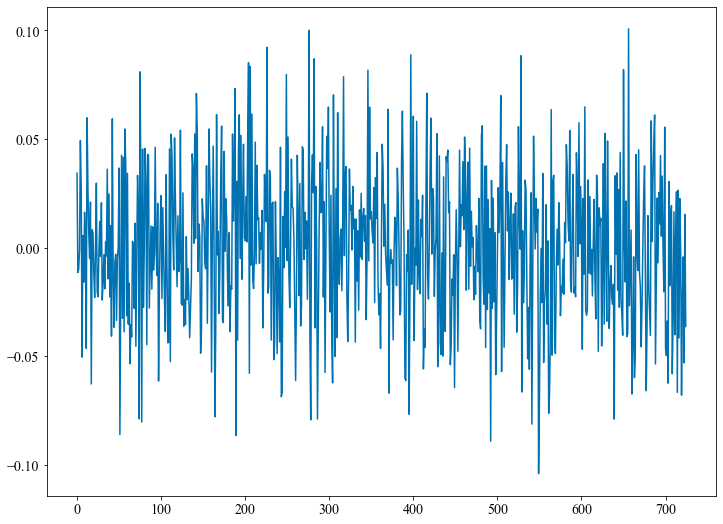

In [82]:
plt.plot(mydata)

In [83]:
myerr

DeviceArray([0.00252824, 0.00205252, 0.00188727, 0.00269821, 0.0019094 ,
             0.00161995, 0.00205294, 0.0021886 , 0.002311  , 0.0022471 ,
             0.00254956, 0.00225862, 0.00318942, 0.00236548, 0.0025567 ,
             0.00273099, 0.00205024, 0.00223721, 0.00181417, 0.00247673,
             0.00248345, 0.00201396, 0.00186369, 0.00246558, 0.00270364,
             0.00253177, 0.0021343 , 0.00232223, 0.00172971, 0.00232664,
             0.00203544, 0.00356167, 0.00176288, 0.00232907, 0.00268487,
             0.00197805, 0.00251888, 0.00156366, 0.00233913, 0.00290814,
             0.0027171 , 0.00244056, 0.00281267, 0.00173742, 0.00332818,
             0.00328104, 0.00242432, 0.00214714, 0.00238652, 0.001842  ,
             0.00269389, 0.00393811, 0.0018733 , 0.00253968, 0.00228651,
             0.00207544, 0.00237198, 0.00325778, 0.00230881, 0.00305069,
             0.00356819, 0.00203088, 0.00158143, 0.00231009, 0.00250263,
             0.0028034 , 0.0021204 , 0.00241504, 0.

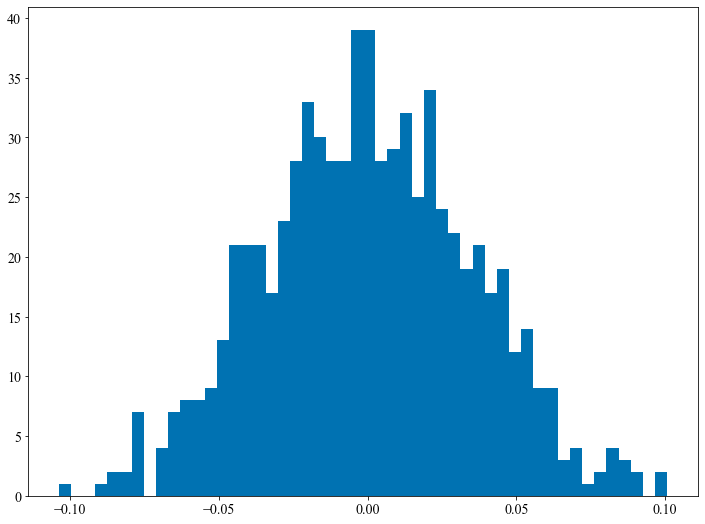

In [84]:
plt.hist(mydata,bins=50);

In [85]:
print("\ncomputing colinearity map...")
gsize = 100 # gsize x gsize grid
gstep = 10 # grid step in mas
xx, yy = np.meshgrid(
        np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
azim = -np.arctan2(xx, yy) * 180.0 / np.pi
dist = np.hypot(xx, yy) * gstep

#mmap = kpo1.kpd_binary_match_map(100, 10, mydata/myerr, norm=True)
mmap_raw = kpo1.kpd_binary_match_map(100, 10, data1, norm=True)
mmap_calib = kpo1.kpd_binary_match_map(100, 10, data2, norm=True)
mmap = kpo1.kpd_binary_match_map(100, 10, mydata, norm=True)

x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
        dist[y0, x0], azim[y0, x0]))



computing colinearity map...
max colinearity found for sep = 100.50 mas and ang = 84.29 deg


In [86]:
vmin, vmax = np.min([mmap_raw,mmap_calib,mmap]), np.max([mmap_raw,mmap_calib,mmap])

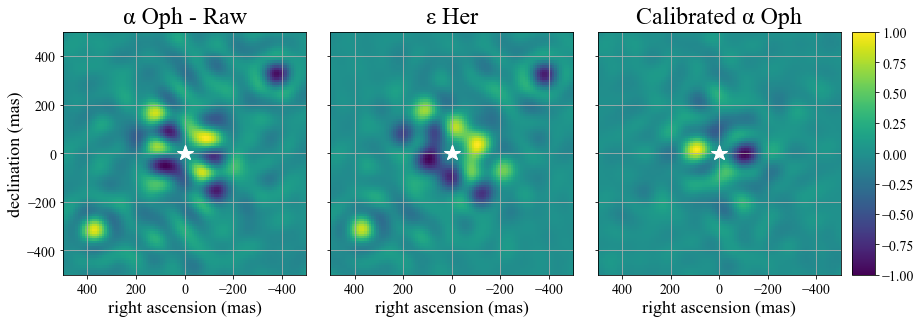

In [87]:

f1, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,5),sharey=True)
f1.subplots_adjust(right=0.8)

ax1.imshow(mmap_raw/mmap_raw.max(), extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax1.set_xlabel("right ascension (mas)")
ax1.set_ylabel("declination (mas)")
ax1.plot([0,0], [0,0], "w*", ms=16)
ax1.set_title("α Oph - Raw",y=1.01)
ax1.grid()

ax2.imshow(mmap_calib/mmap_calib.max(), extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax2.set_xlabel("right ascension (mas)")
# # ax2.set_ylabel("declination (mas)")
ax2.plot([0,0], [0,0], "w*", ms=16)
ax2.set_title("ε Her",y=1.01)
ax2.grid()

im = ax3.imshow(mmap/mmap.max(), extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax3.set_xlabel("right ascension (mas)")
# ax3.set_ylabel("declination (mas)")
ax3.plot([0,0], [0,0], "w*", ms=16)
ax3.set_title("Calibrated α Oph",y=1.01)
ax3.grid()

f1.subplots_adjust(right=0.8,wspace=0.1)
cb_ax = f1.add_axes([0.81, 0.165, 0.02, 0.675])
cbar = f1.colorbar(im, cax=cb_ax)

# f1.set_tight_layout(True)
plt.savefig('../paper/colinearity_alphaoph.pdf', bbox_inches='tight')


In [88]:
from scipy.optimize import leastsq, minimize


def binary_model(params,kpo):
    u = kpo.kpi.UVC[:,0]
    v = kpo.kpi.UVC[:,1]
    wl = kpo.CWAVEL
    detpa = 0
    return(xara.core.cvis_binary_jax(u,v,wl, params, detpa))

def ben_binary_model_fit_residuals(params,kpo=kpo1,index=0,obs="KERNEL",err=1.0):
    temp = binary_model(params,kpo)
    model = np.array(kpo.kpi.KPM).dot(np.angle(temp))
    error = mydata-model
    error /= (err)
    return np.array(error)

def ben_binary_model_fit_chi2(params):
    residuals = ben_binary_model_fit_residuals(params,kpo=kpo1,index=0,obs="KERNEL",err=myerr)
    chi2 = np.sum(np.abs(residuals)**2)
    return chi2

from jax import jit

chi2_jac = jacrev(ben_binary_model_fit_chi2)
chi2_jac_np = lambda x:onp.array(jit(chi2_jac)(x))

def ben_binary_model_fit(p0,kpo=kpo1,index=0,obs='KERNEL',err=myerr):
    soluce = leastsq(ben_binary_model_fit_residuals, 
                 p0, args=((kpo,index, obs,err)), full_output=1)
#     soluce = minimize(ben_binary_model_fit_chi2,p0,method='BFGS',jac=chi2_jac_np)
#     p1 = soluce['x'][0] # the best fit parameter vector (sep, P.A., contrast)
    
    
    return soluce

def get_chi2(addederror):
    return np.sum(((mydata - np.array(ker_theo))/np.sqrt(myerr**2+addederror**2))**2) / (1.0*kpo1.kpi.nbkp)

def add_error():
    def get_objective(addederror):
        return np.abs(get_chi2(addederror)-1.)
    jac = grad(get_objective)
    return minimize(get_objective,0.0025,method='BFGS')['x']



binary model fitting...
added error [0.01842502]
sep = 122.711932, ang=86.414537, con=24.281910 => chi2 = 1.000
correlation matrix of parameters
[[ 2.5  -0.02 -0.9 ]
 [-0.02  0.16  0.01]
 [-0.9   0.01  0.65]]
Estimated Uncertainty
[1.58079265 0.39806463 0.80463505]


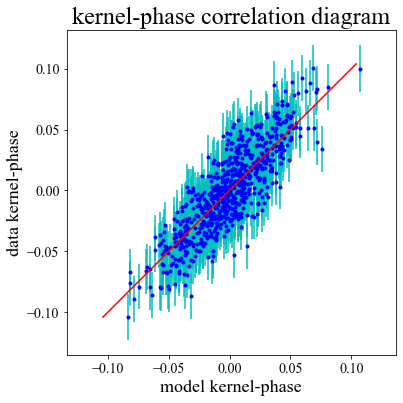

In [89]:
print("\nbinary model fitting...")
# p0 = params0 # good starting point
p0 =  [dist[y0, x0], azim[y0, x0], mmap.max()] # good starting point
p0[1] = np.mod(p0[1],360.)

wl = kpo1.CWAVEL

# mfit = a.binary_model_fit(p0)
mfit = ben_binary_model_fit(p0,kpo=kpo1,err=myerr)

p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)
# p1 = mfit['x']
p1[1] = np.mod(p1[1],360.)
# p1 = p0
# p1 = p0


cvis_b = xara.core.cvis_binary(
        kpo1.kpi.UVC[:,0], kpo1.kpi.UVC[:,1], wl, p1) # binary
ker_theo = kpo1.kpi.KPM.dot(np.angle(cvis_b))

added_error = add_error()
print('added error',added_error)
this_error = np.sqrt(myerr**2+added_error**2)
mfit = ben_binary_model_fit(p0,kpo=kpo1,err=this_error)
p2 = np.array(p1)#+np.sqrt(np.diag(mfit[1]))

cvis_b = xara.core.cvis_binary(
        kpo1.kpi.UVC[:,0], kpo1.kpi.UVC[:,1], wl, p2) # binary
ker_theo = kpo1.kpi.KPM.dot(np.angle(cvis_b))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.errorbar(ker_theo, mydata, yerr=this_error, fmt="none", ecolor='c')
ax.plot(ker_theo, mydata, 'b.')
mmax = (np.abs(mydata).max())
ax.plot([-mmax,mmax],[-mmax,mmax], 'r')
ax.set_ylabel("data kernel-phase")
ax.set_xlabel("model kernel-phase")
ax.set_title('kernel-phase correlation diagram')
ax.axis("equal")
# ax.axis([-11, 11, -11, 11])
fig.set_tight_layout(True)

if myerr is not None:
        chi2 = np.sum(((mydata - ker_theo)/(this_error))**2) / kpo1.kpi.nbkp
else:
        chi2 = np.sum(((mydata - ker_theo))**2) / kpo1.kpi.nbkp

print("sep = %3f, ang=%3f, con=%3f => chi2 = %.3f" % (p1[0], p1[1], p1[2], chi2))
print("correlation matrix of parameters")
# hess_inv = mfit['hess_inv']
hess_inv = mfit[1]
print(np.round(hess_inv, 2))
print('Estimated Uncertainty')
print(np.sqrt(np.diag(hess_inv)))

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.scatter(kpo1.kpi.VAC[:,0],kpo1.kpi.VAC[:,1],c=kpo1.kpi.VAC[:,2],s=4)
plt.scatter(kpo_frantz.kpi.VAC[:,0],kpo_frantz.kpi.VAC[:,1],c='r')

plt.axis('equal')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.scatter(kpo1.kpi.UVC[:,0],kpo1.kpi.UVC[:,1],c=colours[0])

plt.scatter(kpo_frantz.kpi.UVC[:,0],kpo_frantz.kpi.UVC[:,1],s=12,c='r')

plt.axis('equal')

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))

ax1.scatter(kpo1.kpi.VAC[:,0],kpo1.kpi.VAC[:,1],c=kpo1.kpi.VAC[:,2],s=4,label='64 pix')
ax1.scatter(kpo_frantz.kpi.VAC[:,0],kpo_frantz.kpi.VAC[:,1],c='r',label='M+2020')
plt.legend(fontsize=18,frameon=False)
ax1.set_title('Pupil',fontsize=18)
ax1.axis('equal')

ax2.scatter(kpo1.kpi.UVC[:,0],kpo1.kpi.UVC[:,1],c=colours[0],label='64 pix')
ax2.scatter(kpo_frantz.kpi.UVC[:,0],kpo_frantz.kpi.UVC[:,1],s=12,label='M+2020',c='r')
plt.legend(fontsize=18,frameon=False)
ax2.set_title(r'$u,v$',fontsize=18)
ax2.axis('equal')

# plt.savefig('/Users/benjaminpope/code/morphine/paper/pupil_comparison.pdf',bbox_inches='tight')

In [ ]:
kpo1.kpd = mydata

In [ ]:
# kpo1.plot_uv_map()

In [ ]:
xymax = 4.0 
figsize=(12,6)
plot_redun = False
cmap=cm.gray
ssize=12
lw=0
alpha=1.0
marker='s'

In [ ]:
kpo1.kpi.plot_pupil_and_uv(ssize=4);

### Now let's try mcmc

In [ ]:
import emcee

In [ ]:
paramlimits=[40,250,0,360,1.1,50.]

def kp_loglikelihood(params,kpo):
    temp = binary_model(params,kpo)
    model = kpo.kpi.KPM.dot(np.angle(temp))
    error = mydata-model
    error /= (this_error)
    chi2 = -np.sum((error)**2)
    return chi2 

def lnprior(params):
    if paramlimits[0] < params[0] < paramlimits[1] and paramlimits[2] < params[1] < paramlimits[3] and paramlimits[4] < params[2] < paramlimits[5]:
        return -np.log(params[0]) -np.log(params[2])
    return -np.inf

def lnprob(params,kpo):
    return lnprior(params) + kp_loglikelihood(params,kpo)

ndim=3
nwalkers=100
plot=False
burnin=100
nsteps=1000

import time


In [ ]:
p1

In [ ]:
ivar = np.array(p1)  # initial parameters for model-fit

ball = np.array([ivar + 0.1*ivar*onp.random.rand(ndim) for i in range(nwalkers)]) # initialise walkers in a ball

print('Running emcee now!')

t0 = time.time()

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[kpo1])

# burn in
pos,prob,state = sampler.run_mcmc(ball, burnin)
sampler.reset()

t1 = time.time()

print('Burnt in! Took %.3f seconds' %(t1-t0))


In [ ]:
# restart
sampler.run_mcmc(pos,nsteps)

tf = time.time()

print('Time elapsed = %.3f s' %(tf-t0))

seps = sampler.flatchain[:,0]
ths = sampler.flatchain[:,1]

meansep = np.mean(seps)
dsep = np.std(seps)

meanth = np.mean(ths)
dth = np.std(ths)

cs = sampler.flatchain[:,2]
bestcon = np.mean(cs)
conerr = np.std(cs)

print('Separation %.3f pm %.3f mas' % (meansep,dsep))
print('Position angle %.3f pm %.3f deg' % (meanth,dth))
print('Contrast at',wl,'um %.3f pm %.3f' % (bestcon,conerr))


In [ ]:
meansep

In [ ]:
import corner

In [ ]:
# Plot it.
figure = corner.corner(sampler.flatchain, labels=[r"$\rho$", r"$\theta$", r"$c$",],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})


In [ ]:
onp.savetxt('autodiff_128.txt',sampler.flatchain)

### What should we expect from Hinkley?


In [ ]:
Kp_A = 1.68
dKp_A = 0.21

Kp_B =  5.25 
dKp_B = 0.236

In [ ]:
point_est = 100**((Kp_B-Kp_A)/5.)

In [ ]:
nsim = 10000
Kps_A = Kp_A + dKp_A*onp.random.randn(nsim)
Kps_B = Kp_B + dKp_B*onp.random.randn(nsim)

In [ ]:
contrasts_hinkley = 100**((Kps_B-Kps_A)/5.)
print('Hinkley contrast:',np.mean(contrasts_hinkley),'pm',np.std(contrasts_hinkley))

In [ ]:
h = plt.hist(contrasts_hinkley,bins=100);
plt.axvline(point_est,color=colours[2])

## Now try simulated data

In [ ]:
def shift(im,dx,dy):
    input_ = onp.fft.fft2(im)
    result = fourier_shift(input_, shift=(dx,dy))
    return onp.real(onp.fft.ifft2(result))

def sim_binary(im,sep,th,con,pscale):
    sep_pix = sep/pscale
    th_rad = np.pi*th/180.
    dx, dy = sep_pix*np.cos(-th_rad), sep_pix*np.sin(-th_rad)
    shifted = shift(im,dx,dy)
    return im+shifted/con 

def preprocess_like(data,kpo):
    isz = 64
    xsz,ysz = data.shape
    wrad = 50
    pscale = 25.0                              # plate scale (mas)
    cwavel = kpo.CWAVEL  # central wavelength
    m2pix  = xara.core.mas2rad(pscale)*isz/cwavel   # Fourier scaling
    tdiam  = 5.0                               # telescope diameter (m)
    spix   = xara.core.rad2mas(cwavel/tdiam)/pscale # image sampling (pixels)

    (x0, y0) = xara.core.determine_origin(data, mask=None,
                                     algo="BCEN", verbose=False,
                                     wmin=2.0*spix)

    x1, y1 = int(x0-isz/2), int(y0-isz/2)
    img = data[y1:y1+isz, x1:x1+isz] # image is now (isz x isz)
    dy, dx   = (y0-ysz/2), (x0-xsz/2)

    sgmask = xara.core.super_gauss(isz, isz, isz/2, isz/2, wrad)
    (x0, y0) = xara.core.determine_origin(img, mask=sgmask,
                                     algo="BCEN", verbose=False,
                                     wmin=2.0*spix)

    img = xara.core.recenter(data,verbose=False)
    nx,ny = img.shape
    limsx = int(nx/2-64), int(nx/2+64)
    limsy = int(ny/2-64), int(ny/2+64)
    img = img[limsx[0]:limsx[1],limsy[0]:limsy[1]] # from 512x512 -> 128x128
    return img

In [ ]:
(xara.core.super_gauss(64, 64, 64/2, 64/2, 50))

In [ ]:
from scipy.optimize import leastsq, minimize

def simulate(truth,cal):
    binary = sim_binary(cal,*truth,25.0)
    # img_sim = preprocess_like(binary,b)
    img_sim = binary
    a = c.copy()
    wl = kpo1.CWAVEL
    a.extract_KPD_single_frame(
    img_sim, pscale*1000, wl, recenter=True,method='LDFT1')
    mydata = a.KPDT[0][0] - calib
    myerr = np.std(kpo_cal.KPDT[0],axis=0)

    def binary_model(params,kpo):
        u = kpo.kpi.UVC[:,0]
        v = kpo.kpi.UVC[:,1]
        wl = kpo1.CWAVEL
        detpa = 0
        return(xara.core.cvis_binary_jax(u,v,wl, params, detpa))

    def ben_binary_model_fit_residuals(params,kpo=a,index=0,obs="KERNEL",err=1.0):
        temp = binary_model(params,kpo)
        model = np.array(kpo.kpi.KPM).dot(np.angle(temp))
        error = mydata-model
        error /= (err)
        return np.array(error)

    def ben_binary_model_fit_chi2(params):
        residuals = ben_binary_model_fit_residuals(params,kpo=a,index=0,obs="KERNEL",err=myerr)
        chi2 = np.sum(np.abs(residuals)**2)
        return chi2

    from jax import jit

    chi2_jac = jacrev(ben_binary_model_fit_chi2)
    chi2_jac_np = lambda x:onp.array(jit(chi2_jac)(x))

    def ben_binary_model_fit(p0,kpo=a,index=0,obs='KERNEL',err=myerr):
        soluce = leastsq(ben_binary_model_fit_residuals, 
                     p0, args=((kpo,index, obs,err)), full_output=1)
    #     soluce = minimize(ben_binary_model_fit_chi2,p0,method='BFGS',jac=chi2_jac_np)
    #     p1 = soluce['x'][0] # the best fit parameter vector (sep, P.A., contrast)


        return soluce

    
    print("\nbinary model fitting...")
    # p0 = params0 # good starting point
    # p0 =  [dist[y0, x0], azim[y0, x0], mmap.max()] # good starting point

    p0 = truth
    p0[1] = np.mod(p0[1],360.)

    wl = a.CWAVEL

    # mfit = a.binary_model_fit(p0)
    mfit = ben_binary_model_fit(p0,kpo=a,err=myerr)

    p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)
    # p1 = mfit['x']
    p1[1] = np.mod(p1[1],360.)
    # p1 = p0
    # p1 = p0

    cvis_b = xara.core.cvis_binary(
            a.kpi.UVC[:,0], a.kpi.UVC[:,1], wl, p1) # binary
    ker_theo = a.kpi.KPM.dot(np.angle(cvis_b))
    
    def get_chi2(addederror):
        return np.sum(((mydata - np.array(ker_theo))/np.sqrt(myerr**2+addederror**2))**2) / (1.0*a.kpi.nbkp)

    def add_error():
        def get_objective(addederror):
            return np.abs(get_chi2(addederror)-1.)
        jac = grad(get_objective)
        return minimize(get_objective,0.0025,method='BFGS')['x']

    added_error = add_error()
    this_error = np.sqrt(myerr**2+added_error**2)
    mfit = ben_binary_model_fit(p0,kpo=a,err=this_error)
    p2 = mfit[0]

    cvis_b = xara.core.cvis_binary(
            a.kpi.UVC[:,0], a.kpi.UVC[:,1], wl, p2) # binary
    ker_theo = a.kpi.KPM.dot(np.angle(cvis_b))

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    ax.errorbar(ker_theo, mydata, yerr=this_error, fmt="none", ecolor='c')
    ax.plot(ker_theo, mydata, 'b.')
    mmax = (np.abs(mydata).max())
    ax.plot([-mmax,mmax],[-mmax,mmax], 'r')
    ax.set_ylabel("data kernel-phase")
    ax.set_xlabel("model kernel-phase")
    ax.set_title('kernel-phase correlation diagram')
    ax.axis("equal")
    # ax.axis([-11, 11, -11, 11])
    fig.set_tight_layout(True)

    if myerr is not None:
            chi2 = np.sum(((mydata - ker_theo)/(this_error))**2) / a.kpi.nbkp
    else:
            chi2 = np.sum(((mydata - ker_theo))**2) / a.kpi.nbkp

    print("sep = %3f, ang=%3f, con=%3f => chi2 = %.3f" % (p1[0], p1[1], p1[2], chi2))
    print("correlation matrix of parameters")
    # hess_inv = mfit['hess_inv']
    hess_inv = mfit[1]
    print(np.round(hess_inv, 2))
    print('Estimated Uncertainty')
    print(np.sqrt(np.diag(hess_inv)))
    return p2, np.sqrt(np.diag(hess_inv))

In [ ]:
truth = [300,90,20]
cal = ca2_cube[75,:,:]

simulate(truth,cal)

In [ ]:
# %%time
seps_out, thetas_out, cons_out = [], [], []
dseps_out, dthetas_out, dcons_out = [], [], []

kpo_cal = c.copy()
kpo_cal.extract_KPD_single_cube(
        ca2_cube[50:,:,:], pscale*1000, wl, target="epsilon Herculis", recenter=True,method='LDFT1')

calib = np.median(kpo_cal.KPDT[0],axis=0)

ss, tt, cc = [], [], []
seps_in = np.linspace(90,300,50)

for j, sep_in in enumerate(tqdm(seps_in)):
    cal = ca2_cube[0,:,:]
    truth = [sep_in,90,25]
    p1, uncertainty = simulate(truth,cal)
    ss.append(p1[0])
    tt.append(p1[1])
    cc.append(p1[2])
    
    seps_out.append(p1[0])
    thetas_out.append(p1[1])
    cons_out.append(p1[2])

    dseps_out.append(uncertainty[0])
    dthetas_out.append(uncertainty[1])
    dcons_out.append(uncertainty[2])

#     except:
#         print('Failed on',j)
#         seps_out.append(np.nan)
#         thetas_out.append(np.nan)
#         cons_out.append(np.nan)

#         dseps_out.append(np.nan)
#         dthetas_out.append(np.nan)
#         dcons_out.append(np.nan)

seps_out, thetas_out, cons_out = np.array(seps_out), np.array(thetas_out), np.array(cons_out)
dseps_out, dthetas_out, dcons_out = np.array(dseps_out), np.array(dthetas_out), np.array(dcons_out)


In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16.0,4.0))
inds = np.arange(len(seps_in))

ax1.plot(seps_in,seps_out-seps_in,'.')
# ax1.plot(seps_in,seps_in,'--')

ax1.axhline(0,color='k',linestyle='--',alpha=0.5)
ax1.errorbar(seps_in,seps_out-seps_in,yerr=dseps_out,ls='none',color=colours[0])

# ax1.plot(seps_in,seps_in,'--k',alpha=0.5)

ax2.plot(seps_in,thetas_out,'.')
ax2.axhline(truth[1],color='k',linestyle='--',alpha=0.5)
ax2.errorbar(seps_in,thetas_out,yerr=dthetas_out,ls='none',color=colours[0])

ax3.plot(seps_in,cons_out,'.')
ax3.errorbar(seps_in,cons_out,yerr=dcons_out,ls='none',color=colours[0])

ax3.axhline(truth[2],color='k',linestyle='--',alpha=0.5)

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(6.0,16.0),sharex=True)
ax1.plot(seps_in,seps_out,'-')
ax1.fill_between(angles,mseps_out,pseps_out,alpha=0.5)
ax1.axvline(45,color=colours[2])
ax1.axvline(45+180,linestyle='--',color=colours[2])
ax1.set_ylabel('Separation (mas)')
# ax1.set_xlabel('Misalignment (deg)')
ax1.set_xticks([])
ax1.set_xlim(angles.min(),angles.max())
ax1.axhline(truth[0],color='k',linestyle='--',alpha=0.5)
# ax1.plot(seps_in,seps_in,'--k',alpha=0.5)


ax2.plot(angles,thetas_out,'-')
ax2.axhline(truth[1],color='k',linestyle='--',alpha=0.5)
ax2.fill_between(angles,mthetas_out,pthetas_out,alpha=0.5)
ax2.axvline(45,color=colours[2])
ax2.axvline(45+180,linestyle='--',color=colours[2])
ax2.set_ylabel('Position Angle (deg)')
# ax3.set_xlabel('Misalignment (deg)')
ax2.set_xticks([])
# ax2.set_yticks(np.arange(260,272))

ax3.plot(angles,cons_out,'-')
ax3.axhline(truth[2],color='k',linestyle='--',alpha=0.5)
ax3.fill_between(angles,mcons_out,pcons_out,alpha=0.5)
ax3.axvline(45,color=colours[2])
ax3.axvline(45+180,linestyle='--',color=colours[2])
ax3.set_ylabel('Contrast')
ax3.set_xlabel('Misalignment (deg)')
# ax3.set_xticks([0,45,90,135,180,225,270,315])

plt.subplots_adjust(wspace=0, hspace=0)

# plt.savefig('misalignment.png',bbox_inches='tight')
# plt.savefig('misalignment.pdf',bbox_inches='tight')

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(6.0,16.0),sharex=True)
inds = np.arange(len(seps_in))

ax1.plot(seps_in,seps_out-seps_in,'.')
# ax1.plot(seps_in,seps_in,'--')

ax1.axhline(0,color='k',linestyle='--',alpha=0.5)
ax1.errorbar(seps_in,seps_out-seps_in,yerr=dseps_out,ls='none',color=colours[0])
ax1.set_xticks([])
ax1.set_ylabel('Recovered Separation (mas)')
# ax1.plot(seps_in,seps_in,'--k',alpha=0.5)

ax2.plot(seps_in,thetas_out,'.')
ax2.axhline(truth[1],color='k',linestyle='--',alpha=0.5)
ax2.errorbar(seps_in,thetas_out,yerr=dthetas_out,ls='none',color=colours[0])
ax2.set_xticks([])
ax2.set_ylabel('Recovered Position Angle (deg)')

ax3.plot(seps_in,cons_out,'.')
ax3.errorbar(seps_in,cons_out,yerr=dcons_out,ls='none',color=colours[0])

ax3.axhline(truth[2],color='k',linestyle='--',alpha=0.5)
ax3.set_xticks(np.arange(100,350,50))
ax3.set_ylabel('Recovered Contrast')
ax3.set_xlabel('True Separation (mas)')
plt.subplots_adjust(wspace=0, hspace=0)


In [ ]:
to_save = np.array([seps_out, thetas_out, cons_out,dseps_out, dthetas_out, dcons_out]).T
onp.savetxt('autodiff_recovery.txt',to_save)